In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import gym
import numpy as np
import timeit
import matplotlib.pyplot as plt

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
#Define hyperparameters
EPISODES = 1000 #Episode number
EPISODE_LENGTH = 200 #Episode length
GAMMA = 0.9 #Discount factor
ACTOR_LR = 0.0001 #Actor learning rate
CRITIC_LR = 0.0002 #Critic learning rate
UPDATE_TIMES = 10 #Update 10 times for every 32 steps
EPSILON = 0.2 #Clip limit
STD_LIMIT = [1e-2, 1.0] #Standard deviation limit
UPDATE_INTERVAL = 32 #32 batches, update for every 32 steps

In [4]:
class Actor:
    def __init__(self, state_dim, action_dim, action_limit):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_limit = action_limit
        self.model = self.actor_NN()
        self.opt = tf.keras.optimizers.Adam(ACTOR_LR)

    def actor_NN(self):
        state_input = Input((self.state_dim))
        hidden_layer = Dense(100, activation='relu')(state_input)
        mu = Dense(self.action_dim, activation='tanh')(hidden_layer) * self.action_limit
        std = Dense(self.action_dim, activation='softplus')(hidden_layer)
        return tf.keras.models.Model(state_input, [mu, std])

    def get_policy(self, mu, std, action):
        std = tf.clip_by_value(std, STD_LIMIT[0], STD_LIMIT[1])
        var = std ** 2
        log_normal = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(var * 2 * np.pi)
        #print("action=",action, "mu=",mu, "var=",var, 'log_normal1=', log_normal1)
        #print(log_normal1)
        #log_distribution = tfd.LogNormal(loc = mu, scale = std, validate_args=True)
        #log_normal = log_distribution.prob(action)
        #print("log_normal2=", log_normal2)
        return tf.reduce_sum(log_normal, 1, keepdims=True)

    def get_action(self, state_input):
        state_input = np.reshape(state_input, [1, self.state_dim])
        mu, std = self.model.predict(state_input)
        action = np.random.normal(mu[0], std[0], size=self.action_dim)
        action = np.clip(action, -self.action_limit, self.action_limit)
        policy = self.get_policy(mu, std, action)
        return policy, action

    def get_loss(self, old_policy, new_policy, advantage):
        ratio = tf.exp(new_policy - tf.stop_gradient(old_policy))
        advantage = tf.stop_gradient(advantage)
        clipped_ratio = tf.clip_by_value(ratio, 1.0-EPSILON, 1.0+EPSILON)
        loss = -tf.minimum(ratio * advantage, clipped_ratio * advantage)
        return tf.reduce_mean(loss)

    def train(self, old_policy, states, actions, advantage):
        with tf.GradientTape() as t:
            mu, std = self.model(states, training=True)
            new_policy = self.get_policy(mu, std, actions)
            loss = self.get_loss(old_policy, new_policy, advantage)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss


In [5]:
class Critic:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.critic_NN()
        self.opt = tf.keras.optimizers.Adam(CRITIC_LR)

    def critic_NN(self):
        return tf.keras.Sequential([
            Input((self.state_dim)),
            Dense(100, activation='relu'),
            Dense(1, activation='linear')])

    def get_loss(self, value_pred, td_targets):
        loss = tf.keras.losses.MeanSquaredError()
        return loss(td_targets, value_pred)

    def train(self, states, td_targets):
        with tf.GradientTape() as t:
            value_pred = self.model(states, training=True)
            assert value_pred.shape == td_targets.shape
            loss = self.get_loss(tf.stop_gradient(td_targets), value_pred)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss

In [6]:
def get_advantage(rewards, values, next_value, done):
    td_targets = np.zeros_like(rewards)
    advantage = np.zeros_like(rewards)
    forward_value = 0

    if not done:
        forward_value = next_value

    for k in reversed(range(0, len(rewards))):
        advantage[k] = GAMMA * forward_value + rewards[k]- values[k]
        forward_value = values[k]
        td_targets[k] = advantage[k] + values[k]
    return advantage, td_targets

In [7]:
def batch(batch_list):
    batch = batch_list[0]
    for bat in batch_list[1:]:
        batch = np.append(batch, bat, axis=0)
    return batch

In [8]:
def train(EPISODES, environment):
    state_dim = environment.observation_space.shape[0]
    action_dim = environment.action_space.shape[0]
    action_limit = environment.action_space.high[0]
    actor = Actor(state_dim, action_dim, action_limit)
    critic = Critic(state_dim)
    episode_reward_list_moving_average = []
    episode_reward_list = []
    start = timeit.default_timer()

    for episode in range(EPISODES):
        state_list = []
        action_list = []
        reward_list = []
        old_policy_list = []
        episode_reward= 0
        current_state = environment.reset()

        for move in range(EPISODE_LENGTH):
            old_policy, action = actor.get_action(current_state)
            next_state, reward, done, _ = environment.step(action)
            current_state = np.reshape(current_state, [1, state_dim])
            action = np.reshape(action, [1, 1])
            next_state = np.reshape(next_state, [1, state_dim])
            reward = np.reshape(reward, [1, 1])
            old_policy = np.reshape(old_policy, [1, 1])
            state_list.append(current_state)
            action_list.append(action)
            reward_list.append((reward+8)/8) #Normalize reward
            old_policy_list.append(old_policy)

            if (move+1) % UPDATE_INTERVAL ==0 or move == EPISODE_LENGTH-1:
                states = batch(state_list)
                actions = batch(action_list)
                rewards = batch(reward_list)
                old_policys = batch(old_policy_list)
                values = critic.model.predict(states)
                next_value = critic.model.predict(next_state)
                advantages, td_targets = get_advantage(rewards, values, next_value, done)
                
                #Update actor and critic
                for epoch in range(UPDATE_TIMES):
                    actor_loss = actor.train(old_policys, states, actions, advantages)
                    critic_loss = critic.train(states, td_targets)
                #Reset the lists after updates
                state_list = []
                action_list = []
                reward_list = []
                old_policy_list = []

            episode_reward += reward[0][0]
            current_state = next_state[0]

        episode_reward_list.append(episode_reward)

        if episode == 0: #Get reward for each episode
            episode_reward_list_moving_average.append(episode_reward)
        else: #Get moving average reward for each episode
            episode_reward_list_moving_average.append(episode_reward_list_moving_average[-1]*0.9 + episode_reward * 0.1)

        print('EP {} EpisodeReward = {}'.format(episode, episode_reward))
    stop = timeit.default_timer()
    print('Time taken:{}'.format(stop - start))

    return episode_reward_list_moving_average, episode_reward_list

In [ ]:
environment = gym.make("Pendulum-v0")
PPO_train = train(EPISODES, environment)

EP 0 EpisodeReward = -1585.0288989649891
EP 1 EpisodeReward = -1753.5386136657758
EP 2 EpisodeReward = -1858.8492284466863
EP 3 EpisodeReward = -1738.009318639032
EP 4 EpisodeReward = -1684.9648407308712
EP 5 EpisodeReward = -1752.5053832767887
EP 6 EpisodeReward = -1873.5369380032391
EP 7 EpisodeReward = -1761.0352773102163
EP 8 EpisodeReward = -1621.8644155642462
EP 9 EpisodeReward = -1646.3415771205082
EP 10 EpisodeReward = -1787.1168354261451
EP 11 EpisodeReward = -1763.9976113359805
EP 12 EpisodeReward = -1648.1036608340587
EP 13 EpisodeReward = -1538.7406696660269
EP 14 EpisodeReward = -1720.542869887226
EP 15 EpisodeReward = -1636.7810408072382
EP 16 EpisodeReward = -1429.005995515539
EP 17 EpisodeReward = -1651.830218762342
EP 18 EpisodeReward = -1536.5991451842656
EP 19 EpisodeReward = -1781.2296604067762
EP 20 EpisodeReward = -1757.787334475522
EP 21 EpisodeReward = -1463.2547019725994
EP 22 EpisodeReward = -1732.36071406228
EP 23 EpisodeReward = -1315.7716660348417
EP 24 Epi

In [ ]:
episode_reward_list_moving_average, episode_reward_list = PPO_train

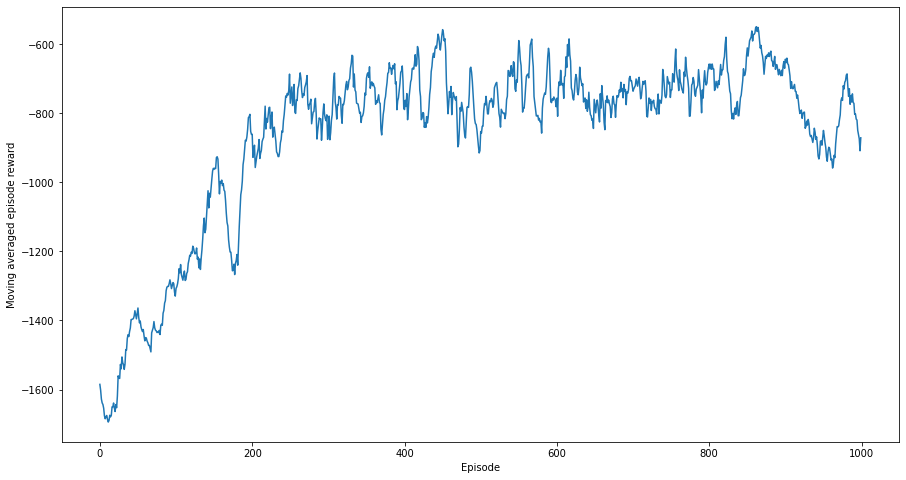

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(np.arange(len(episode_reward_list_moving_average)), episode_reward_list_moving_average)
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()

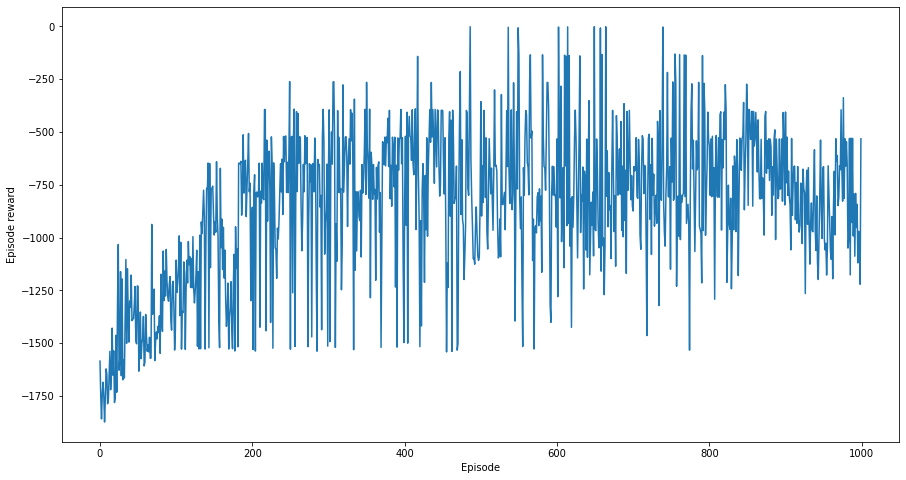

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(np.arange(len(episode_reward_list)), episode_reward_list)
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.show()

In [9]:
environment2 = gym.make("MountainCarContinuous-v0")
PPO_train2 = train(EPISODES, environment2)

EP 0 EpisodeReward = -6.545950426682544
EP 1 EpisodeReward = -7.458509018237504
EP 2 EpisodeReward = -6.8631600601698
EP 3 EpisodeReward = -5.673102110063361
EP 4 EpisodeReward = -6.222533956822731
EP 5 EpisodeReward = -5.526430231430056
EP 6 EpisodeReward = -4.7141872917494725
EP 7 EpisodeReward = -5.804878859878285
EP 8 EpisodeReward = -5.009297780474162
EP 9 EpisodeReward = -5.945027565795621
EP 10 EpisodeReward = -4.869651078174882
EP 11 EpisodeReward = -4.866794435959092
EP 12 EpisodeReward = -4.100879484226125
EP 13 EpisodeReward = -4.246401370686269
EP 14 EpisodeReward = -5.176554635258551
EP 15 EpisodeReward = -4.859202296131266
EP 16 EpisodeReward = -3.8111904272800428
EP 17 EpisodeReward = -3.926491623622544
EP 18 EpisodeReward = -3.4080433878467056
EP 19 EpisodeReward = -3.914602359113473
EP 20 EpisodeReward = -3.4035576767076443
EP 21 EpisodeReward = -3.830870195011947
EP 22 EpisodeReward = -3.3988619521491756
EP 23 EpisodeReward = -3.8366346151470427
EP 24 EpisodeReward = 

In [10]:
episode_reward_list_moving_average2, episode_reward_list2 = PPO_train2

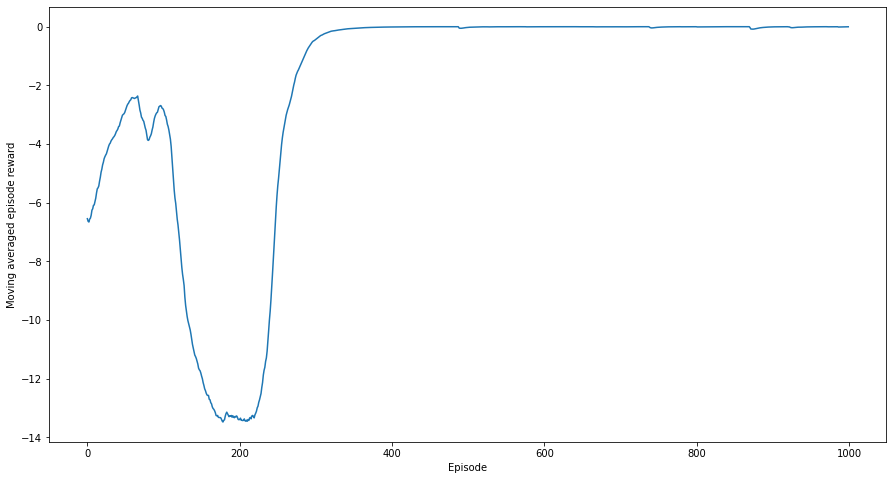

In [11]:
plt.figure(figsize = (15,8))
plt.plot(np.arange(len(episode_reward_list_moving_average2)), episode_reward_list_moving_average2)
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()

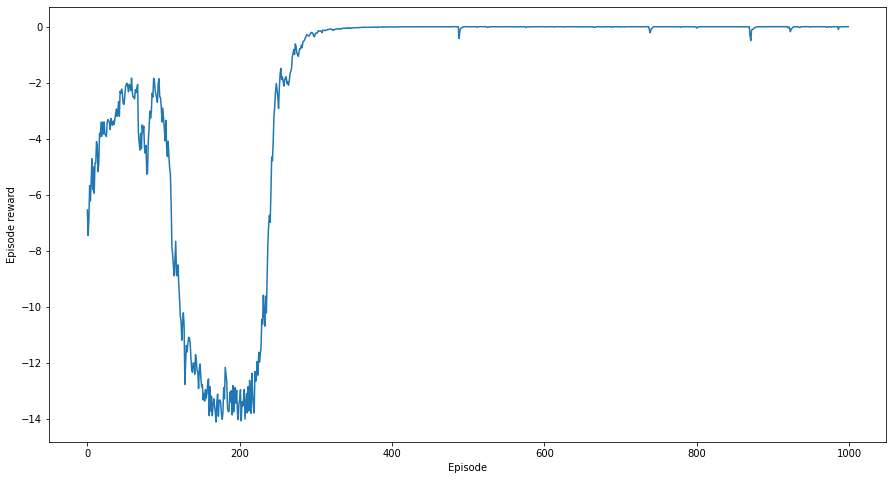

In [12]:
plt.figure(figsize = (15,8))
plt.plot(np.arange(len(episode_reward_list2)), episode_reward_list2)
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.show()

###### Reference & Framework:
https://github.com/marload/DeepRL-TensorFlow2/blob/master/PPO/PPO_Continuous.py
https://github.com/marload/DeepRL-TensorFlow2/blob/master/PPO/PPO_Discrete.py